In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd 
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

In [3]:
def findColumnsWithHighCorrelation(copy_sampled_extracted_training_data_2015):
  corr_matrix_2015 = copy_sampled_extracted_training_data_2015.corr().abs()
  upper_2015 = corr_matrix_2015.where(np.triu(np.ones(corr_matrix_2015.shape), k=1).astype(np.bool))
  high_correlation_cols_2015 = [column for column in upper_2015.columns if any(upper_2015[column] > 0.90)]
  return high_correlation_cols_2015

In [4]:
def downsample(extracted_training_data_2015):
  yes_samples = extracted_training_data_2015[extracted_training_data_2015['lung_issues'] == 1]
  no_samples = extracted_training_data_2015[extracted_training_data_2015['lung_issues'] == 0]
  down_no_sampled = no_samples.sample(len(yes_samples))

  sampled_extracted_training_data_2015 = pd.concat([yes_samples, down_no_sampled])
  
  return sampled_extracted_training_data_2015

In [5]:
def preprocess(filepath):

  data_2015 = pd.read_csv(filepath)
  print(f'Rows: {data_2015.shape[0]} and Cols: {data_2015.shape[1]}')

  # merge all related column values into a new target column for lung diseases
  data_2015['lung_issues'] = data_2015.ASTHMA3
  data_2015.lung_issues = np.where(data_2015.CHCCOPD1.eq(1), data_2015.CHCCOPD1, data_2015.lung_issues)
  data_2015.lung_issues = np.where(data_2015.ASTHNOW.eq(1), data_2015.ASTHNOW, data_2015.lung_issues)

  print("Shape (1) => ", data_2015[data_2015.lung_issues == 1].shape)

  # drop all columns whose values have already been combined into target disease column
  data_2015 = data_2015.drop(['ASTHMA3', 'ASTHNOW', 'CHCCOPD1'], axis=1)

  # from codebook we notice that the "No" values are shown as 2 in target disease column, we replace them with 0
  data_2015.lung_issues.replace([2], 0, inplace=True)

  # drop all NAN values in target disease column
  data_2015.dropna(subset=['lung_issues'], inplace=True)

  # drop derived columns (names start with underscore)
  derived_columns = []
  for column in data_2015.columns:
    if column.startswith('_') and column != '_RACE':
      derived_columns.append(column)
      data_2015.drop(column, axis=1, inplace=True)

  print("Shape (2) => ", data_2015.shape)

  # drop all columns where more than 90% values are NAN
  nan_threshold = 90.0
  min_count =  int(((100-nan_threshold)/100)*data_2015.shape[0] + 1)
  mod_data_2015 = data_2015.dropna(axis=1, thresh=min_count)

  print("Shape (3) => ", mod_data_2015.shape)

  # drop columns with little information, ie. the columns with low standard deviation.
  low_deviation_columns = mod_data_2015.std()[(mod_data_2015.std() == 0)].index
  mod_data_2015.drop(low_deviation_columns, axis=1, inplace=True)

  print("Shape (4) => ", mod_data_2015.shape)

  # drop all the columns with datatype as object (since all other columns are float64)
  mod_data_2015 = mod_data_2015.select_dtypes(exclude=['object'])

  print("Shape (5) => ", mod_data_2015.shape)

  filled_data_2015 = mod_data_2015.fillna(-1)

  extracted_training_data_2015 = filled_data_2015.loc[~filled_data_2015.lung_issues.isin([7,9])]
  extracted_test_data_2015 = filled_data_2015.loc[filled_data_2015.lung_issues.isin([7,9])]

  return extracted_training_data_2015, extracted_test_data_2015

In [17]:
print("-------------------------------- Preprocessing dataset ----------------------------------")

extracted_training_data_2015, extracted_test_data_2015 = preprocess('/content/drive/MyDrive/Colab Notebooks/data/2015.csv')
print(extracted_training_data_2015.shape)
print(extracted_test_data_2015.shape)

print("-------------------------------- Downsampling 'No' class ---------------------------------")

sampled_extracted_training_data_2015 = downsample(extracted_training_data_2015)
copy_sampled_extracted_training_data_2015 = sampled_extracted_training_data_2015.copy()

training_target_2015 = copy_sampled_extracted_training_data_2015[['lung_issues']]
test_target_2015 = extracted_test_data_2015[['lung_issues']]

copy_sampled_extracted_training_data_2015.drop(columns=['lung_issues'], inplace=True)
extracted_test_data_2015.drop(columns=['lung_issues'], inplace=True)

print("---------------------------- DimRed using Columnar Correlation ----------------------------")

high_correlation_cols_2015 = findColumnsWithHighCorrelation(copy_sampled_extracted_training_data_2015)
copy_sampled_extracted_training_data_2015.drop(high_correlation_cols_2015, axis=1,inplace = True)

print(copy_sampled_extracted_training_data_2015.shape)

print("------------------------------ Normalizing training data ----------------------------------")
ss_scaler = preprocessing.StandardScaler()
extracted_training_data_ss = ss_scaler.fit_transform(copy_sampled_extracted_training_data_2015)

extracted_training_data_ss_df = pd.DataFrame(data=extracted_training_data_ss[0:,0:], columns=copy_sampled_extracted_training_data_2015.columns)
extracted_training_data_ss_df.dropna(inplace=True, axis=1, how='all')

print(extracted_training_data_ss_df.shape)

print("-------------------------------------- Training model -------------------------------------")
model = XGBClassifier()
x_train, x_test, y_train, y_test = train_test_split(extracted_training_data_ss_df, training_target_2015, shuffle = True, test_size=0.2, random_state=42)
model.fit(x_train, y_train)

-------------------------------- Preprocessing dataset ----------------------------------
Rows: 441456 and Cols: 330
Shape (1) =>  (80332, 331)
Shape (2) =>  (441456, 253)
Shape (3) =>  (441456, 151)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Shape (4) =>  (441456, 148)
Shape (5) =>  (441456, 141)
(440291, 141)
(1165, 141)
-------------------------------- Downsampling 'No' class ---------------------------------
---------------------------- DimRed using Columnar Correlation ----------------------------
(160664, 120)
------------------------------ Normalizing training data ----------------------------------
(160664, 120)
-------------------------------------- Training model -------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier()

------------------------- Extracting features based on importance --------------------------


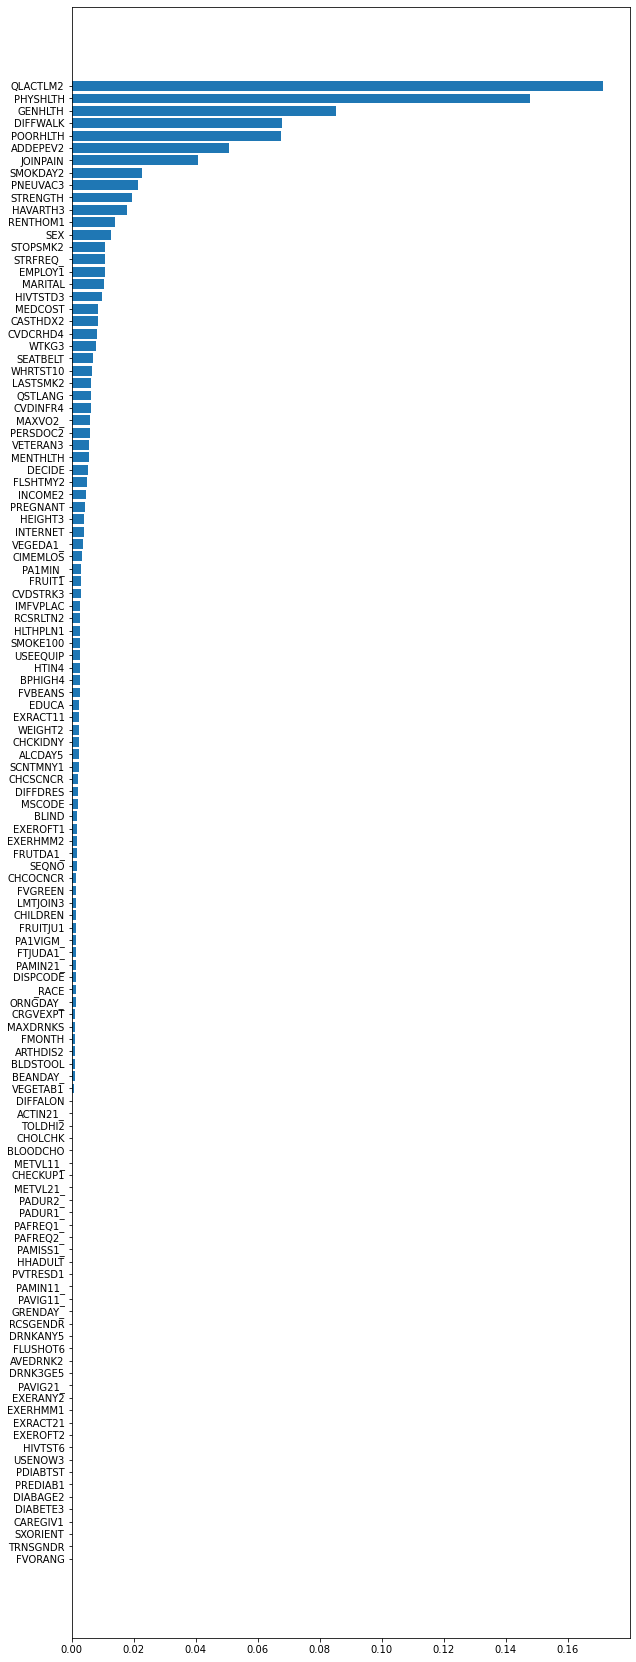

In [18]:
print("------------------------- Extracting features based on importance --------------------------")
sorted_columns = model.feature_importances_.argsort()
plt.figure(figsize=(10,30))
plt.barh(copy_sampled_extracted_training_data_2015.columns[sorted_columns], model.feature_importances_[sorted_columns])

shortlisted_columns = copy_sampled_extracted_training_data_2015.columns[sorted_columns][-50:]

In [19]:
print("------------------------- Detailed classification report --------------------------")
print()
y_true, y_pred = y_test, model.predict(x_test)
print(classification_report(y_true, y_pred))

------------------------- Detailed classification report --------------------------

              precision    recall  f1-score   support

         0.0       0.66      0.72      0.69     16111
         1.0       0.69      0.62      0.65     16022

    accuracy                           0.67     32133
   macro avg       0.67      0.67      0.67     32133
weighted avg       0.67      0.67      0.67     32133



In [20]:
print("------------------------- Just keep 50 most relevant cols --------------------------")
print(shortlisted_columns)

------------------------- Just keep 50 most relevant cols --------------------------
Index(['FVBEANS', 'BPHIGH4', 'HTIN4', 'USEEQUIP', 'SMOKE100', 'HLTHPLN1',
       'RCSRLTN2', 'IMFVPLAC', 'CVDSTRK3', 'FRUIT1', 'PA1MIN_', 'CIMEMLOS',
       'VEGEDA1_', 'INTERNET', 'HEIGHT3', 'PREGNANT', 'INCOME2', 'FLSHTMY2',
       'DECIDE', 'MENTHLTH', 'VETERAN3', 'PERSDOC2', 'MAXVO2_', 'CVDINFR4',
       'QSTLANG', 'LASTSMK2', 'WHRTST10', 'SEATBELT', 'WTKG3', 'CVDCRHD4',
       'CASTHDX2', 'MEDCOST', 'HIVTSTD3', 'MARITAL', 'EMPLOY1', 'STRFREQ_',
       'STOPSMK2', 'SEX', 'RENTHOM1', 'HAVARTH3', 'STRENGTH', 'PNEUVAC3',
       'SMOKDAY2', 'JOINPAIN', 'ADDEPEV2', 'POORHLTH', 'DIFFWALK', 'GENHLTH',
       'PHYSHLTH', 'QLACTLM2'],
      dtype='object')


In [22]:
final_columns = ['lung_issues']
for column in shortlisted_columns:
  final_columns.append(column)

print(final_columns)
print(len(final_columns))

sampled_extracted_training_data_2015.drop(sampled_extracted_training_data_2015.columns.difference(final_columns), 1, inplace=True)
sampled_extracted_training_data_2015.shape

['lung_issues', 'FVBEANS', 'BPHIGH4', 'HTIN4', 'USEEQUIP', 'SMOKE100', 'HLTHPLN1', 'RCSRLTN2', 'IMFVPLAC', 'CVDSTRK3', 'FRUIT1', 'PA1MIN_', 'CIMEMLOS', 'VEGEDA1_', 'INTERNET', 'HEIGHT3', 'PREGNANT', 'INCOME2', 'FLSHTMY2', 'DECIDE', 'MENTHLTH', 'VETERAN3', 'PERSDOC2', 'MAXVO2_', 'CVDINFR4', 'QSTLANG', 'LASTSMK2', 'WHRTST10', 'SEATBELT', 'WTKG3', 'CVDCRHD4', 'CASTHDX2', 'MEDCOST', 'HIVTSTD3', 'MARITAL', 'EMPLOY1', 'STRFREQ_', 'STOPSMK2', 'SEX', 'RENTHOM1', 'HAVARTH3', 'STRENGTH', 'PNEUVAC3', 'SMOKDAY2', 'JOINPAIN', 'ADDEPEV2', 'POORHLTH', 'DIFFWALK', 'GENHLTH', 'PHYSHLTH', 'QLACTLM2']
51


(160664, 51)

In [23]:
sampled_extracted_training_data_2015.to_csv('Train_Lung_Issues.csv', index=False) 

In [24]:
extracted_test_data_2015.to_csv('Test_Lung_Issues.csv', index=False) 

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=1)

# x_bal, y_bal = sm.fit_resample(x_train, y_train)

In [ ]:
# model.fit(x_bal, y_bal)